## Is Scotland meeting current emissions targets, and on track to meet future targets?


The Scottish government has set a goal of reaching net-zero greenhouse gas (GHG) emissions against 1990 levels by the year 2045. The government has also set itself interim targets in order to achieve this, notably a 75% reduction by 2030.

In this project we will:
- look at Scottish Government GHG data from 1990 to 2020, and measure this against the government's own reported goals.
    - as we have access to industry-level data, we can check which industries are best and worst performing in this regard too.
    - we also can review the data by the specific pollutant, so it may also be interesting to look at the differences between each gas
- interpolate the data out to 2030, to see if the Scottish government is on track to meet this goal.

The dataset can be found here (entitled <i>Greenhouse Gas Dataset</i>):
https://www.gov.scot/publications/scottish-greenhouse-gas-statistics-2020/documents/

The Scottish government's goals can be found here:
https://www.gov.scot/policies/climate-change/reducing-emissions/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#importing the data
df = pd.read_csv('ghg_scotland_2020.csv')

In [3]:
df.head(3)

,NCFormat,IPCC_code,IPCC_name,SourceName,CRF,Old_SG_name,CCP_category,Pollutant,EmissionYear,Emmisions (MtCO2e)
0,Agriculture,1A4ci,1A4ci_Agriculture/Forestry/Fishing:Stationary,Agriculture - stationary combustion,Energy,Agriculture and related land use,Agriculture,CH4,BaseYear,0.000887
1,Agriculture,1A4ci,1A4ci_Agriculture/Forestry/Fishing:Stationary,Agriculture - stationary combustion,Energy,Agriculture and related land use,Agriculture,CH4,1990,0.000887
2,Agriculture,1A4ci,1A4ci_Agriculture/Forestry/Fishing:Stationary,Agriculture - stationary combustion,Energy,Agriculture and related land use,Agriculture,CH4,1995,0.000778


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22446 entries, 0 to 22445
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NCFormat            22446 non-null  object 
 1   IPCC_code           22446 non-null  object 
 2   IPCC_name           22446 non-null  object 
 3   SourceName          22446 non-null  object 
 4   CRF                 22446 non-null  object 
 5   Old_SG_name         22446 non-null  object 
 6   CCP_category        22446 non-null  object 
 7   Pollutant           22446 non-null  object 
 8   EmissionYear        22446 non-null  object 
 9   Emmisions (MtCO2e)  22446 non-null  float64
dtypes: float64(1), object(9)
memory usage: 1.7+ MB


The columns are as follows:
- <b>Columns 0-6: </b> outline different ways of determining the industry being reported, including the Common Reporting Framework (CRF), Intergovernmental Panel on Climate Change (IPCC) and the Scottish Government (SG) categories. <i>While some categories go into more detail than others, we'll use the same category as the Scottish Government does in its reports, being the NCFormat column.</i>
- <b>Pollutant: </b> the specific gas being measured
- <b>EmissionYear: </b> the year the gas was measured
- <b>Emissions (MtCO2e)</b>: the quantity of the gas in equivalent CO2, units in megatonnes.

### Cleaning

In [5]:
#converting all column names to lowercase
df.columns = df.columns.str.lower()
df.rename(columns={'emissionyear':'emission_year', 'emmisions (mtco2e)':'mt_co2e'}, inplace=True)

In [6]:
df['ncformat'].value_counts().sort_values()

Public                                      78
Residential                                364
Waste Management                           598
Exports                                   1156
Industrial processes                      1181
Land use, land use change and forestry    1716
Energy Supply                             2516
Business                                  2964
Transport                                 3166
Agriculture                               8707
Name: ncformat, dtype: int64

Some industries larger than others by the look of it. Can confirm by breaking down and checking against a more nuanced category, e.g. sourcename.

In [7]:
df['sourcename'].value_counts()

Autogenerators                           208
Excreta                                  208
Managed Manure                           208
Enteric                                  182
Iron and steel - combustion plant        156
                                        ... 
Crop Digestates - Direct                  10
Crop Digestates - Indirect Deposition     10
Crop Digestates - Indirect Leach          10
Gas Terminal: Direct Process               6
Oil Terminal: Direct Process               6
Name: sourcename, Length: 481, dtype: int64

Looks like that's fine. As long as each industry in question has data back to 1990, which should be listed as the 'BaseYear', then we can use it.

In [8]:
df[df['emission_year'] == '1990'].groupby('ncformat')['emission_year'].value_counts().sort_values()

ncformat                                emission_year
Public                                  1990               3
Residential                             1990              14
Waste Management                        1990              23
Exports                                 1990              46
Industrial processes                    1990              47
Land use, land use change and forestry  1990              66
Energy Supply                           1990             100
Business                                1990             114
Transport                               1990             120
Agriculture                             1990             256
Name: emission_year, dtype: int64

These are the same names as we saw above when calling the ncformat values. We also have no null values, so I am satisfied there is sufficient data available since 1990.


## Analysis

Let's now take a look at the 1990-2020 data to see if it is meeting the Scottish government goal for 2020. To measure this, we'll need to:

- Find the 2020 goal for Scotland (it's 56% of the Baseline year, 1990 or 1995 depending on the industry/pollutant)

- Sum the Mt_Co2e data for each industry
- Plot the sum of each industy against each year
- Create a dataset that measures the Scottish government's goal so we can compare in the same plot.

### Import the Scottish Government's Goal

- Take the Baseyear Mt CO2e level for each pollutant and industry
- Sum the baseyear levels for each industry or pollutant, as appropriate for analysis
- Sum the levels for each year by industry/pollutant as appropriate, then assess the percentage difference between that figure and the baseline year figure.

We'll start with industry

In [9]:
df['base_year'] = df['emission_year'] == 'BaseYear'
df.head(1)

,ncformat,ipcc_code,ipcc_name,sourcename,crf,old_sg_name,ccp_category,pollutant,emission_year,mt_co2e,base_year
0,Agriculture,1A4ci,1A4ci_Agriculture/Forestry/Fishing:Stationary,Agriculture - stationary combustion,Energy,Agriculture and related land use,Agriculture,CH4,BaseYear,0.000887,True


In [10]:
industries = df.groupby(['ncformat','emission_year'])['mt_co2e'].sum()
industries = pd.DataFrame(industries)
industries = industries.reset_index()
industries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ncformat       260 non-null    object 
 1   emission_year  260 non-null    object 
 2   mt_co2e        260 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.2+ KB


In [11]:
#Adding a column that tracks the BaseYear level, so we can measure against it
industries['base_level'] = industries.groupby('ncformat').mt_co2e.transform('first')

In [12]:
#Now adding a column that calculates the percentage of emissions for each year, compared to the base_level

industries['pct_of_baselevel'] = round(industries['mt_co2e']/industries['base_level']*100,2)


#Removing the 'BaseYear' data
base = ['BaseYear']
industries = industries[~industries.emission_year.isin(base)]
industries['emission_year'] = industries['emission_year'].astype(int)

Now we can add in the Scottish Government's targets so they will plot alongside our reduction. I've compiled these manually to a csv from the Scottish Govt website

In [14]:
targets = pd.read_csv('scotgov_targets.csv')
targets_df = pd.DataFrame(targets)
industries_2 = industries.copy()

In [15]:
later_years = list(np.arange(2021,2046,1))
industries_2 = industries_2[~industries_2.emission_year.isin(later_years)]

In [52]:
#Calculating the percentage reduction from 1990 levels (if increase, will go to negative)
industries_2['pct_reduction'] = 100-industries_2['pct_of_baselevel']

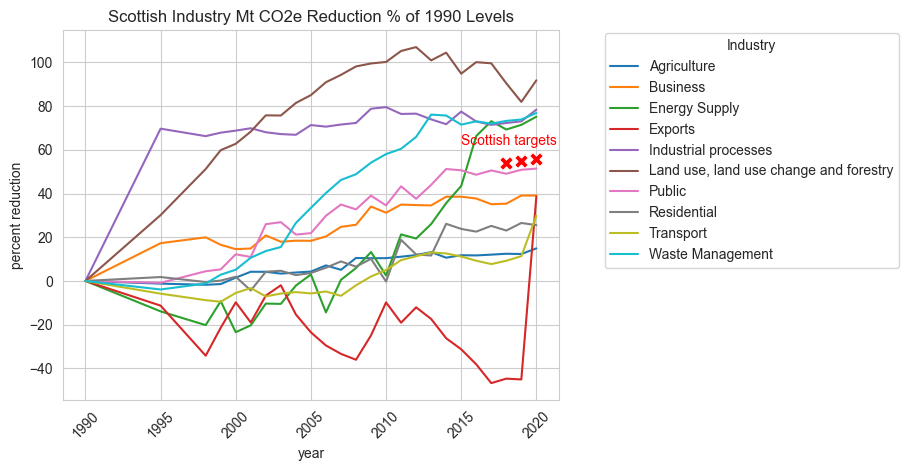

In [51]:
#Now just to plot
sns.set_style("whitegrid")
fig, ax = plt.subplots()
ax1 = sns.lineplot(data=industries_2,x='emission_year', y='pct_reduction', hue='ncformat')
ax2 = sns.scatterplot(data=targets_df[targets_df['emission_year'] < 2021], x='emission_year', y='pct_of_baselevel',
               marker='X', color='red', s=100)
plt.xticks(rotation=45)
plt.title('Scottish Industry Mt CO2e Reduction % of 1990 Levels')

ax.set(xlabel='year', ylabel='percent reduction')
ax.set_xticks([1990,1995,2000,2005,2010,2015,2020])

ax.text(.9, .7, 'Scottish targets', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, color='red')

sns.move_legend(ax, "center right", bbox_to_anchor=(1.7, .675), ncol=1, title='Industry', frameon=True)
plt.show()

### Discuss
From the above we can see that there is a lot of variation between Scottish industries in their emissions reduction performance.

We have some industries overreaching and beating the Scottish Government target, e.g. Land Use and Waste Management. Waste Management shows a trend that looks set to continue reducing emissions over time, and this is true also for Public (presumably, the Public Sector) and Energy Supply.

While Industrial Processes looks to have been exceeding targets for a number of years, it has also remained stagnant in terms of change since 1995. This indicates a need to drive further change in that industry, as government targets will become more aggressive in coming years.

Underperformers include the Agriculture industry, Business and notably, Exports. I do not have confidence that the drop in emissions from 2020 will continue into future years' reporting, as this sudden drop is likely due to the COVID-19 pandemic reducing the capacity for Exports globally, as transport was significantly limited.